Проверка обучения предобученной модели через фреймворк Flair

# Подготовка

In [ ]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.2/387.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 61.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 119.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1

In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.embeddings import BytePairEmbeddings
from flair.embeddings import DocumentPoolEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.data import Sentence

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.style.use('bmh')
# Переменные
path_ds2 = '/content/drive/MyDrive/Media108/DS2/'                # Папка с датасетами 2
path_ds = '/content/drive/MyDrive/Media108/DS/'                  # Папка с датасетами
path_dataset = '/content/drive/MyDrive/Media108/DATASET/'        # Обобщающая папка для датасетов
path_dir = '/content/drive/MyDrive/Media108/'                    # Общий путь для сохранения результатов
list_txt = ['DS/Расшифровки_Записи звонков_павелецкая сити',
            'DS/Расшифровки_Записи звонков_хедлайнер',
            'DS/Расшифровки_Записи звонков_primavera'
            'DS2/Расшифровки_Записи Павелецкая сити',
            'DS2/Расшифровки_Записи Headliner',
            'DS2/Расшифровки_Записи Primavera']                     # Папки с расшифровками разговоров
name_of_dir = ['DS/Записи звонков_павелецкая сити',
               'DS/Записи звонков_хедлайнер',
               'DS/Записи звонков_primavera'
               'DS2/Записи Павелецкая сити',
               'DS2/Записи Headliner',
               'DS2/Записи Primavera']                              # Папки с аудиозаписями  2

np.random.seed(42)


<Figure size 1200x600 with 0 Axes>

# Процедуры

In [ ]:
# Процедура поочередного преобразования колонок через LabelEncoder
def df_to_le(df,collist,lst_encoders = {}):
    '''
 Процедура поочередного преобразования колонок из списка через LabelEncoder
 Параметры:
 df - датафрейм
 collist - список колонок
 lst_encoders - ранее сформированные энкодеры (для работы с обученной моделью)
 Возвращает измененный датафрейм и список энкодеров (для последующего декодирования)
    '''
    create_encode = True if len(lst_encoders) == 0 else False
    list_code = []
    for i in range(len(collist)):
        if create_encode:
            print(f'Формирование Labelencoder и кодировка колонки {collist[i]}', end='')
            encoder = LabelEncoder()
            encoder.fit(df[collist[i]].tolist())
            lst_encoders[collist[i]] = encoder
            df[collist[i]] = encoder.transform(df[collist[i]].values.astype('str'))
            print(' - Успешно')
        else:
            #print(f'Кодируется колонка {collist[i]}', end='')
            encoder = lst_encoders[collist[i]]
            df[collist[i]] = encoder.transform(df[collist[i]].values.astype('str'))
            #print(' - Успешно')

    return df, lst_encoders

def df_to_ohe(df,collist,lst_encoders = {}):
    '''
 Процедура поочередного преобразования колонок из списка через LabelEncoder в ОНЕ
 С последующей сборкой в единый массив. Параметры:
 df - датафрейм
 collist - список колонок
 Возвращает собранный массив и список энкодеров
    '''
    create_encode = True if len(lst_encoders) == 0 else False
    #print(create_encode)
    list_code = []
    for i in range(len(collist)):
        if create_encode:
            print(f'Формирование Labelencoder и кодировка колонки {collist[i]}', end='')
            encoder = LabelEncoder()
            encoder.fit(df[collist[i]].tolist())
            lst_encoders[collist[i]] = encoder
            list_code.append(utils.to_categorical(encoder.transform(df[collist[i]].tolist()),df[collist[i]].nunique()))
            print(' - Успешно')
        else:
            #print(f'Кодируется колонка {collist[i]}', end='')
            encoder = lst_encoders[collist[i]]
            list_code.append(utils.to_categorical(encoder.transform(df[collist[i]].tolist()),len((encoder.classes_))))
            #print(' - Успешно')

    x_data = np.hstack(list_code)
    return x_data, lst_encoders

In [ ]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

# Подготовка Датасета

In [ ]:
df_all = pd.read_csv(path_dir+'df_new_3klass.csv')

In [ ]:
df_all.head()

,Unnamed: 0,Name,Имя файла,Текст_whisper,Длина текста,Количество слов,Статус,Тип,Дата и время,Номер абонента,...,Client ID Яндекс.Метрика,ID ресурса Google Analytics,ID счетчика Яндекс.Метрика,URL страницы обращения,Длительность разговора,Длительность постобработки,Чистая длительность разговора,Полная длительность ожидания,Расширенная UTM-метка Source,klass
0,0,Павелецкая сити,2023-07-18_13-51-59.127269_from_78005055934_to...,безответа,10.0,1.0,Принятый,Динамический коллтрекинг,2023-07-18 13:51:58,78005055934,...,NaN,NaN,NaN,https://pavcity.turbo.site/page2987565/,1,00:00:00,1,00:00:01,yandex,0
1,1,Павелецкая сити,2023-07-11_18-13-13.999706_from_79274147009_to...,здравствуйте,14.0,1.0,Принятый,Динамический коллтрекинг,2023-07-11 18:13:13,79274147009,...,NaN,NaN,NaN,https://pavcity.turbo.site/page2987565/,3,00:00:00,3,00:00:01,yandex,0
2,2,Павелецкая сити,2023-06-27_15-04-43.293132_from_79036175926_to...,здравствуйте вы позвонили в компанию эмргрупп ...,279.0,34.0,Принятый,Аналитика,2023-06-27 15:04:42,79036175926,...,NaN,NaN,NaN,NaN,20,00:00:00,20,00:00:02,NaN,0
3,3,Павелецкая сити,2023-06-19_20-04-39.492518_from_79274574090_to...,здравствуйте,14.0,1.0,Принятый,Динамический коллтрекинг,2023-06-19 20:04:38,79274574090,...,NaN,NaN,NaN,https://pavcity.turbo.site/page2987565/,3,00:00:00,2,00:00:02,yandex,0
4,4,Headliner,2023-07-19_17-12-58.258412_from_79991345109_to...,здравствуйте вы позвонили в группу компании ка...,3246.0,530.0,Принятый,Динамический коллтрекинг,2023-07-19 17:12:54,79991345109,...,1.689774e+18,UA-111037154-1,46973610.0,https://head-liner.ru/catalog/filter/,394,00:00:00,394,00:00:05,NaN,2


<Axes: >

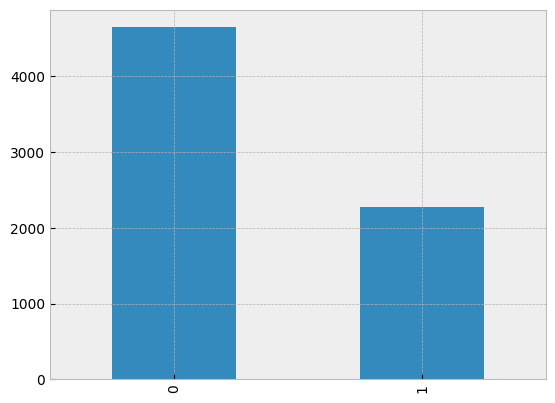

In [ ]:
df_all['Признак'].value_counts().plot.bar()

<Axes: >

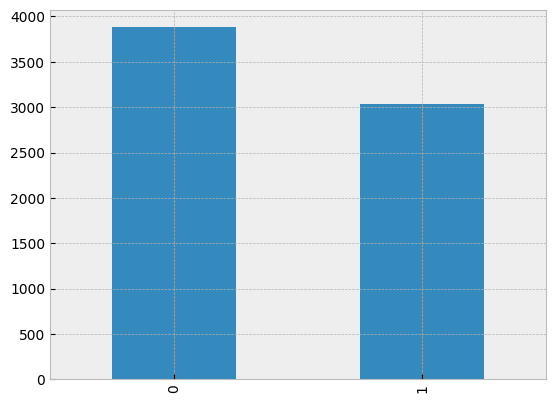

In [ ]:
df_all['Target'].value_counts().plot.bar()

In [ ]:
df_all['Текст_whisper'] = df_all['Текст_whisper'].str.replace('ё', 'е', regex=False)

# Эксперименты

## Эксперимент 1

используется колонка "Признак"

In [ ]:
del df
df = df_all[['Текст_whisper','Признак']].copy()

In [ ]:
df = df.rename(columns={'Текст_whisper': 'text', 'Признак': 'sentiment'})

In [ ]:
df.head()

,text,sentiment
0,безответа,0
1,здравствуйте,0
2,здравствуйте вы позвонили в компанию эмргрупп ...,0
3,здравствуйте,0
4,здравствуйте вы позвонили в группу компании ка...,1


In [ ]:
df = df.reindex(columns=['sentiment', 'text'])

In [ ]:
df.sentiment = '__label__' + df.sentiment.apply(str)
df.head()

,sentiment,text
0,__label__0,безответа
1,__label__0,здравствуйте
2,__label__0,здравствуйте вы позвонили в компанию эмргрупп ...
3,__label__0,здравствуйте
4,__label__1,здравствуйте вы позвонили в группу компании ка...


In [ ]:
df.head()

In [ ]:
tr_df, validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
train, test = train_test_split(tr_df, test_size=0.25, random_state=42, stratify=tr_df['sentiment'])
train_df.shape[0], val_df.shape[0], test_df.shape[0]

In [ ]:
train, validate, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=42)
train.shape[0], validate.shape[0], test.shape[0]

(4152, 1384, 1385)

In [ ]:
path_txt = '/content/drive/MyDrive/Media108/TXT_DATA/'
train.to_csv(path_txt +'sentiment.train.fasttext',
             sep=' ',
             index=False,
             header=None)
validate.to_csv(path_txt +'sentiment.validate.fasttext',
                sep=' ',
                index=False,
                header=None)
test.to_csv(path_txt +'sentiment.test.fasttext',
            sep=' ',
            index=False,
            header=None)


In [ ]:
del corpus
corpus: Corpus = ClassificationCorpus(
    path_txt,
    train_file='sentiment.train.fasttext',
    dev_file='sentiment.validate.fasttext',
    test_file='sentiment.test.fasttext')
#    in_memory=False)

2023-11-02 10:33:54,243 Reading data from /content/drive/MyDrive/Media108/TXT_DATA
2023-11-02 10:33:54,246 Train: /content/drive/MyDrive/Media108/TXT_DATA/sentiment.train.fasttext
2023-11-02 10:33:54,250 Dev: /content/drive/MyDrive/Media108/TXT_DATA/sentiment.validate.fasttext
2023-11-02 10:33:54,253 Test: /content/drive/MyDrive/Media108/TXT_DATA/sentiment.test.fasttext
2023-11-02 10:33:55,402 Initialized corpus /content/drive/MyDrive/Media108/TXT_DATA/ (label type name is 'class')


In [ ]:
print(len(corpus.train), len(corpus.dev), len(corpus.test), sep=', ')

4152, 1384, 1385


In [ ]:
corpus.train.tokenizer

In [ ]:
label_dict = corpus.make_label_dictionary(label_type='class')

2023-11-02 10:34:08,154 Computing label dictionary. Progress:


0it [00:00, ?it/s]
4152it [00:32, 127.97it/s]

2023-11-02 10:34:40,620 Dictionary created for label 'class' with 2 values: 0 (seen 2786 times), 1 (seen 1366 times)


In [ ]:
bpe = BytePairEmbeddings(language='ru', dim=100, syllables=50000)

downloading https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs50000.model


100%|██████████| 1404906/1404906 [00:00<00:00, 2268205.51B/s]


downloading https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs50000.d100.w2v.bin.tar.gz


100%|██████████| 19076003/19076003 [00:01<00:00, 15333770.36B/s]


In [ ]:
document_emb = DocumentPoolEmbeddings([bpe], fine_tune_mode='nonlinear')

In [ ]:
print(document_emb)

DocumentPoolEmbeddings(
  fine_tune_mode=nonlinear, pooling=mean
  (embeddings): StackedEmbeddings(
    (list_embedding_0): BytePairEmbeddings(model=0-bpe-ru-50000-100)
  )
  (embedding_flex): Linear(in_features=200, out_features=200, bias=False)
  (embedding_flex_nonlinear): ReLU()
  (embedding_flex_nonlinear_map): Linear(in_features=200, out_features=200, bias=True)
)


In [ ]:
# Инициализируем текстовый классификатор
classifier = TextClassifier(document_emb, label_dictionary=label_dict,label_type='class')

# По умолчанию в качестве оптимизатора используется SGD.
# Мы будем использовать его, поэтому не указываем явно тип оптимизатора:
trainer = ModelTrainer(classifier, corpus)

# Если же нужно использовать какой-то иной алгоритм, его нужно указать:
#
# from torch.optim.adam import Adam
# trainer = ModelTrainer(classifier, corpus, optimizer=Adam)


In [ ]:
trainer.train(
    path_dir+'/model',
    learning_rate=0.1,
    mini_batch_size=64,
    anneal_factor=0.5,
    patience=5,
    max_epochs=20)
#    monitor_train=True)

2023-11-02 10:41:25,919 ----------------------------------------------------------------------------------------------------
2023-11-02 10:41:25,927 Model: "TextClassifier(
  (embeddings): DocumentPoolEmbeddings(
    fine_tune_mode=nonlinear, pooling=mean
    (embeddings): StackedEmbeddings(
      (list_embedding_0): BytePairEmbeddings(model=0-bpe-ru-50000-100)
    )
    (embedding_flex): Linear(in_features=200, out_features=200, bias=False)
    (embedding_flex_nonlinear): ReLU()
    (embedding_flex_nonlinear_map): Linear(in_features=200, out_features=200, bias=True)
  )
  (decoder): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (weights): None
  (weight_tensor) None
)"
2023-11-02 10:41:25,932 ----------------------------------------------------------------------------------------------------
2023-11-02 10:41:25,937 Corpus

100%|██████████| 22/22 [00:49<00:00,  2.25s/it]

2023-11-02 10:44:41,505 DEV : loss 0.3398153781890869 - f1-score (micro avg)  0.8642


2023-11-02 10:44:53,325  - 0 epochs without improvement
2023-11-02 10:44:53,337  - 0 epochs without improvement
2023-11-02 10:44:53,346  - 0 epochs without improvement
2023-11-02 10:44:53,352 saving best model
2023-11-02 10:44:53,563 ----------------------------------------------------------------------------------------------------
2023-11-02 10:45:05,447 epoch 2 - iter 6/65 - loss 0.42350951 - time (sec): 11.88 - samples/sec: 32.32 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:45:19,671 epoch 2 - iter 12/65 - loss 0.36406454 - time (sec): 26.10 - samples/sec: 29.42 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:45:32,114 epoch 2 - iter 18/65 - loss 0.36210871 - time (sec): 38.55 - samples/sec: 29.88 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:45:49,483 epoch 2 - iter 24/65 - loss 0.34937122 - time (sec): 55.92 - samples/sec: 27.47 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:46:02,617 epoch 2 - iter 30/65 - loss 0.37336042 - time (sec): 69.05 - samples/sec: 27.81 - 

100%|██████████| 22/22 [00:48<00:00,  2.18s/it]

2023-11-02 10:48:08,940 DEV : loss 0.3345772325992584 - f1-score (micro avg)  0.8642


2023-11-02 10:48:20,021  - 0 epochs without improvement
2023-11-02 10:48:20,033  - 0 epochs without improvement
2023-11-02 10:48:20,043  - 0 epochs without improvement
2023-11-02 10:48:20,051 ----------------------------------------------------------------------------------------------------
2023-11-02 10:48:35,188 epoch 3 - iter 6/65 - loss 0.33520414 - time (sec): 15.13 - samples/sec: 25.38 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:48:46,505 epoch 3 - iter 12/65 - loss 0.33169274 - time (sec): 26.45 - samples/sec: 29.04 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:49:00,019 epoch 3 - iter 18/65 - loss 0.33328718 - time (sec): 39.96 - samples/sec: 28.83 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:49:13,827 epoch 3 - iter 24/65 - loss 0.34221459 - time (sec): 53.77 - samples/sec: 28.57 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:49:27,897 epoch 3 - iter 30/65 - loss 0.34193264 - time (sec): 67.84 - samples/sec: 28.30 - lr: 0.100000 - momentum: 0.000000
2023-11-

100%|██████████| 22/22 [00:48<00:00,  2.19s/it]

2023-11-02 10:51:36,783 DEV : loss 0.31349432468414307 - f1-score (micro avg)  0.8829


2023-11-02 10:51:48,457  - 0 epochs without improvement
2023-11-02 10:51:48,470  - 0 epochs without improvement
2023-11-02 10:51:48,480  - 0 epochs without improvement
2023-11-02 10:51:48,490 saving best model
2023-11-02 10:51:48,656 ----------------------------------------------------------------------------------------------------
2023-11-02 10:52:00,259 epoch 4 - iter 6/65 - loss 0.36258537 - time (sec): 11.58 - samples/sec: 33.17 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:52:15,659 epoch 4 - iter 12/65 - loss 0.33460017 - time (sec): 26.98 - samples/sec: 28.47 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:52:29,859 epoch 4 - iter 18/65 - loss 0.34464381 - time (sec): 41.18 - samples/sec: 27.98 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:52:44,310 epoch 4 - iter 24/65 - loss 0.34259657 - time (sec): 55.63 - samples/sec: 27.61 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:53:00,437 epoch 4 - iter 30/65 - loss 0.33904046 - time (sec): 71.76 - samples/sec: 26.76 - 

100%|██████████| 22/22 [00:51<00:00,  2.33s/it]

2023-11-02 10:55:09,697 DEV : loss 0.3046844005584717 - f1-score (micro avg)  0.8923


2023-11-02 10:55:20,747  - 0 epochs without improvement
2023-11-02 10:55:20,759  - 0 epochs without improvement
2023-11-02 10:55:20,768  - 0 epochs without improvement
2023-11-02 10:55:20,777 saving best model
2023-11-02 10:55:20,933 ----------------------------------------------------------------------------------------------------
2023-11-02 10:55:35,160 epoch 5 - iter 6/65 - loss 0.38642455 - time (sec): 14.20 - samples/sec: 27.04 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:55:47,718 epoch 5 - iter 12/65 - loss 0.31802468 - time (sec): 26.76 - samples/sec: 28.70 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:56:00,625 epoch 5 - iter 18/65 - loss 0.31354293 - time (sec): 39.67 - samples/sec: 29.04 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:56:16,262 epoch 5 - iter 24/65 - loss 0.33166208 - time (sec): 55.30 - samples/sec: 27.77 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:56:31,095 epoch 5 - iter 30/65 - loss 0.34768705 - time (sec): 70.14 - samples/sec: 27.38 - 

100%|██████████| 22/22 [00:49<00:00,  2.24s/it]

2023-11-02 10:58:40,027 DEV : loss 0.33497491478919983 - f1-score (micro avg)  0.8801


2023-11-02 10:58:50,977  - 1 epochs without improvement
2023-11-02 10:58:50,988  - 1 epochs without improvement
2023-11-02 10:58:50,998  - 1 epochs without improvement
2023-11-02 10:58:51,007 ----------------------------------------------------------------------------------------------------
2023-11-02 10:59:05,031 epoch 6 - iter 6/65 - loss 0.38969692 - time (sec): 14.02 - samples/sec: 27.40 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:59:20,600 epoch 6 - iter 12/65 - loss 0.36465091 - time (sec): 29.59 - samples/sec: 25.96 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:59:32,516 epoch 6 - iter 18/65 - loss 0.32816602 - time (sec): 41.50 - samples/sec: 27.76 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:59:44,678 epoch 6 - iter 24/65 - loss 0.32148172 - time (sec): 53.66 - samples/sec: 28.62 - lr: 0.100000 - momentum: 0.000000
2023-11-02 10:59:58,685 epoch 6 - iter 30/65 - loss 0.31623491 - time (sec): 67.67 - samples/sec: 28.37 - lr: 0.100000 - momentum: 0.000000
2023-11-

100%|██████████| 22/22 [00:47<00:00,  2.15s/it]

2023-11-02 11:02:04,003 DEV : loss 0.35170692205429077 - f1-score (micro avg)  0.8721


2023-11-02 11:02:15,414  - 2 epochs without improvement
2023-11-02 11:02:15,427  - 2 epochs without improvement
2023-11-02 11:02:15,436  - 2 epochs without improvement
2023-11-02 11:02:15,446 ----------------------------------------------------------------------------------------------------
2023-11-02 11:02:31,226 epoch 7 - iter 6/65 - loss 0.29478136 - time (sec): 15.77 - samples/sec: 24.34 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:02:45,741 epoch 7 - iter 12/65 - loss 0.30801099 - time (sec): 30.29 - samples/sec: 25.36 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:03:01,896 epoch 7 - iter 18/65 - loss 0.30480283 - time (sec): 46.44 - samples/sec: 24.80 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:03:13,009 epoch 7 - iter 24/65 - loss 0.31389778 - time (sec): 57.56 - samples/sec: 26.69 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:03:28,045 epoch 7 - iter 30/65 - loss 0.32128576 - time (sec): 72.59 - samples/sec: 26.45 - lr: 0.100000 - momentum: 0.000000
2023-11-

100%|██████████| 22/22 [00:47<00:00,  2.18s/it]

2023-11-02 11:05:53,262 DEV : loss 0.2997250556945801 - f1-score (micro avg)  0.8909


2023-11-02 11:06:05,318  - 3 epochs without improvement
2023-11-02 11:06:05,329  - 3 epochs without improvement
2023-11-02 11:06:05,340  - 3 epochs without improvement
2023-11-02 11:06:05,350 ----------------------------------------------------------------------------------------------------
2023-11-02 11:06:20,593 epoch 8 - iter 6/65 - loss 0.26021998 - time (sec): 15.23 - samples/sec: 25.21 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:06:36,868 epoch 8 - iter 12/65 - loss 0.29430663 - time (sec): 31.51 - samples/sec: 24.37 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:06:53,858 epoch 8 - iter 18/65 - loss 0.30150620 - time (sec): 48.50 - samples/sec: 23.75 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:07:03,533 epoch 8 - iter 24/65 - loss 0.30147329 - time (sec): 58.17 - samples/sec: 26.40 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:07:19,288 epoch 8 - iter 30/65 - loss 0.30526812 - time (sec): 73.93 - samples/sec: 25.97 - lr: 0.100000 - momentum: 0.000000
2023-11-

100%|██████████| 22/22 [00:47<00:00,  2.17s/it]

2023-11-02 11:09:25,750 DEV : loss 0.3427242934703827 - f1-score (micro avg)  0.8793


2023-11-02 11:09:34,768  - 4 epochs without improvement
2023-11-02 11:09:34,780  - 4 epochs without improvement
2023-11-02 11:09:34,788  - 4 epochs without improvement
2023-11-02 11:09:34,807 ----------------------------------------------------------------------------------------------------
2023-11-02 11:09:36,440 ----------------------------------------------------------------------------------------------------
2023-11-02 11:09:36,448 Exiting from training early.
2023-11-02 11:09:36,451 Saving model ...
2023-11-02 11:09:36,595 Done.
2023-11-02 11:09:36,599 ----------------------------------------------------------------------------------------------------
2023-11-02 11:09:36,603 Loading model from best epoch ...


100%|██████████| 22/22 [00:48<00:00,  2.22s/it]

2023-11-02 11:10:26,686 
Results:
- F-score (micro) 0.8816
- F-score (macro) 0.8704
- Accuracy 0.8816

By class:
              precision    recall  f1-score   support

           0     0.9532    0.8678    0.9085       938
           1     0.7665    0.9105    0.8323       447

    accuracy                         0.8816      1385
   macro avg     0.8598    0.8892    0.8704      1385
weighted avg     0.8929    0.8816    0.8839      1385

2023-11-02 11:10:26,693 ----------------------------------------------------------------------------------------------------


{'test_score': 0.8815884476534296}

## Эксперимент 2

используется колонка "Target"

In [ ]:
#del df
df = df_all[['Текст_whisper','Target']].copy()

In [ ]:
df = df.rename(columns={'Текст_whisper': 'text', 'Target': 'sentiment'})

In [ ]:
df.head()

,text,sentiment
0,безответа,0
1,здравствуйте,0
2,здравствуйте вы позвонили в компанию эмргрупп ...,0
3,здравствуйте,0
4,здравствуйте вы позвонили в группу компании ка...,1


In [ ]:
df = df.reindex(columns=['sentiment', 'text'])

In [ ]:
df.sentiment = '__label__' + df.sentiment.apply(str)
df.head()

,sentiment,text
0,__label__0,безответа
1,__label__0,здравствуйте
2,__label__0,здравствуйте вы позвонили в компанию эмргрупп ...
3,__label__0,здравствуйте
4,__label__1,здравствуйте вы позвонили в группу компании ка...


In [ ]:
df.head()

In [ ]:
train, validate, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=42)
train.shape[0], validate.shape[0], test.shape[0]

(4152, 1384, 1385)

In [ ]:
path_txt = '/content/drive/MyDrive/Media108/TXT_DATA/'
train.to_csv(path_txt +'sentiment.train.fasttext',
             sep=' ',
             index=False,
             header=None)
validate.to_csv(path_txt +'sentiment.validate.fasttext',
                sep=' ',
                index=False,
                header=None)
test.to_csv(path_txt +'sentiment.test.fasttext',
            sep=' ',
            index=False,
            header=None)


In [ ]:
#del corpus
corpus: Corpus = ClassificationCorpus(
    path_txt,
    train_file='sentiment.train.fasttext',
    dev_file='sentiment.validate.fasttext',
    test_file='sentiment.test.fasttext')
#    in_memory=False)

2023-11-02 11:25:22,620 Reading data from /content/drive/MyDrive/Media108/TXT_DATA
2023-11-02 11:25:22,623 Train: /content/drive/MyDrive/Media108/TXT_DATA/sentiment.train.fasttext
2023-11-02 11:25:22,624 Dev: /content/drive/MyDrive/Media108/TXT_DATA/sentiment.validate.fasttext
2023-11-02 11:25:22,626 Test: /content/drive/MyDrive/Media108/TXT_DATA/sentiment.test.fasttext
2023-11-02 11:25:23,343 Initialized corpus /content/drive/MyDrive/Media108/TXT_DATA/ (label type name is 'class')


In [ ]:
print(len(corpus.train), len(corpus.dev), len(corpus.test), sep=', ')

4152, 1384, 1385


In [ ]:
corpus.train.tokenizer

In [ ]:
label_dict = corpus.make_label_dictionary(label_type='class')

2023-11-02 11:25:39,770 Computing label dictionary. Progress:


0it [00:00, ?it/s]
4152it [00:20, 198.33it/s]

2023-11-02 11:26:00,761 Dictionary created for label 'class' with 2 values: 0 (seen 2325 times), 1 (seen 1827 times)


In [ ]:
bpe = BytePairEmbeddings(language='ru', dim=100, syllables=50000)

downloading https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs50000.model


100%|██████████| 1404906/1404906 [00:01<00:00, 1401430.08B/s]


downloading https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs50000.d100.w2v.bin.tar.gz


100%|██████████| 19076003/19076003 [00:02<00:00, 7778867.77B/s] 


In [ ]:
document_emb = DocumentPoolEmbeddings([bpe], fine_tune_mode='nonlinear')

In [ ]:
print(document_emb)

DocumentPoolEmbeddings(
  fine_tune_mode=nonlinear, pooling=mean
  (embeddings): StackedEmbeddings(
    (list_embedding_0): BytePairEmbeddings(model=0-bpe-ru-50000-100)
  )
  (embedding_flex): Linear(in_features=200, out_features=200, bias=False)
  (embedding_flex_nonlinear): ReLU()
  (embedding_flex_nonlinear_map): Linear(in_features=200, out_features=200, bias=True)
)


In [ ]:
# Инициализируем текстовый классификатор
classifier = TextClassifier(document_emb, label_dictionary=label_dict,label_type='class')

# По умолчанию в качестве оптимизатора используется SGD.
# Мы будем использовать его, поэтому не указываем явно тип оптимизатора:
trainer = ModelTrainer(classifier, corpus)

# Если же нужно использовать какой-то иной алгоритм, его нужно указать:
#
# from torch.optim.adam import Adam
# trainer = ModelTrainer(classifier, corpus, optimizer=Adam)


In [ ]:
trainer.train(
    path_dir+'model2',
    learning_rate=0.1,
    mini_batch_size=64,
    anneal_factor=0.5,
    patience=5,
    max_epochs=10)
#    monitor_train=True)

2023-11-02 11:27:02,007 ----------------------------------------------------------------------------------------------------
2023-11-02 11:27:02,010 Model: "TextClassifier(
  (embeddings): DocumentPoolEmbeddings(
    fine_tune_mode=nonlinear, pooling=mean
    (embeddings): StackedEmbeddings(
      (list_embedding_0): BytePairEmbeddings(model=0-bpe-ru-50000-100)
    )
    (embedding_flex): Linear(in_features=200, out_features=200, bias=False)
    (embedding_flex_nonlinear): ReLU()
    (embedding_flex_nonlinear_map): Linear(in_features=200, out_features=200, bias=True)
  )
  (decoder): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (weights): None
  (weight_tensor) None
)"
2023-11-02 11:27:02,013 ----------------------------------------------------------------------------------------------------
2023-11-02 11:27:02,016 Corpus

100%|██████████| 22/22 [00:47<00:00,  2.15s/it]

2023-11-02 11:30:11,310 DEV : loss 0.397018700838089 - f1-score (micro avg)  0.836


2023-11-02 11:30:18,029  - 0 epochs without improvement
2023-11-02 11:30:18,041 saving best model
2023-11-02 11:30:18,170 ----------------------------------------------------------------------------------------------------
2023-11-02 11:30:30,777 epoch 2 - iter 6/65 - loss 0.33645856 - time (sec): 12.60 - samples/sec: 30.47 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:30:46,806 epoch 2 - iter 12/65 - loss 0.35553564 - time (sec): 28.63 - samples/sec: 26.82 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:30:59,584 epoch 2 - iter 18/65 - loss 0.36084770 - time (sec): 41.41 - samples/sec: 27.82 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:31:12,265 epoch 2 - iter 24/65 - loss 0.37316604 - time (sec): 54.09 - samples/sec: 28.40 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:31:25,418 epoch 2 - iter 30/65 - loss 0.36827486 - time (sec): 67.25 - samples/sec: 28.55 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:31:36,262 epoch 2 - iter 36/65 - loss 0.36322405 - time (sec): 7

100%|██████████| 22/22 [00:47<00:00,  2.17s/it]

2023-11-02 11:33:26,885 DEV : loss 0.36462417244911194 - f1-score (micro avg)  0.8801


2023-11-02 11:33:34,169  - 0 epochs without improvement
2023-11-02 11:33:34,176 saving best model
2023-11-02 11:33:34,275 ----------------------------------------------------------------------------------------------------
2023-11-02 11:33:46,172 epoch 3 - iter 6/65 - loss 0.33875560 - time (sec): 11.88 - samples/sec: 32.31 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:33:56,848 epoch 3 - iter 12/65 - loss 0.33576431 - time (sec): 22.56 - samples/sec: 34.04 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:34:10,328 epoch 3 - iter 18/65 - loss 0.36568876 - time (sec): 36.04 - samples/sec: 31.96 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:34:23,998 epoch 3 - iter 24/65 - loss 0.35944039 - time (sec): 49.71 - samples/sec: 30.90 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:34:37,157 epoch 3 - iter 30/65 - loss 0.37680768 - time (sec): 62.87 - samples/sec: 30.54 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:34:53,882 epoch 3 - iter 36/65 - loss 0.37792466 - time (sec): 7

100%|██████████| 22/22 [00:47<00:00,  2.17s/it]

2023-11-02 11:36:44,104 DEV : loss 0.4558561444282532 - f1-score (micro avg)  0.771


2023-11-02 11:36:49,813  - 1 epochs without improvement
2023-11-02 11:36:49,820 ----------------------------------------------------------------------------------------------------
2023-11-02 11:37:03,597 epoch 4 - iter 6/65 - loss 0.40110785 - time (sec): 13.77 - samples/sec: 27.88 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:37:16,782 epoch 4 - iter 12/65 - loss 0.38713170 - time (sec): 26.96 - samples/sec: 28.49 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:37:29,917 epoch 4 - iter 18/65 - loss 0.37577303 - time (sec): 40.09 - samples/sec: 28.73 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:37:43,103 epoch 4 - iter 24/65 - loss 0.38456238 - time (sec): 53.28 - samples/sec: 28.83 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:37:52,916 epoch 4 - iter 30/65 - loss 0.37345233 - time (sec): 63.09 - samples/sec: 30.43 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:38:08,248 epoch 4 - iter 36/65 - loss 0.37474818 - time (sec): 78.42 - samples/sec: 29.38 - lr: 0.100000 -

100%|██████████| 22/22 [00:48<00:00,  2.22s/it]

2023-11-02 11:40:08,111 DEV : loss 0.318513423204422 - f1-score (micro avg)  0.8786


2023-11-02 11:40:13,841  - 2 epochs without improvement
2023-11-02 11:40:13,849 ----------------------------------------------------------------------------------------------------
2023-11-02 11:40:28,634 epoch 5 - iter 6/65 - loss 0.30609260 - time (sec): 14.78 - samples/sec: 25.98 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:40:41,336 epoch 5 - iter 12/65 - loss 0.31529164 - time (sec): 27.48 - samples/sec: 27.95 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:40:52,481 epoch 5 - iter 18/65 - loss 0.32831561 - time (sec): 38.63 - samples/sec: 29.82 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:41:04,905 epoch 5 - iter 24/65 - loss 0.33115101 - time (sec): 51.05 - samples/sec: 30.09 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:41:19,351 epoch 5 - iter 30/65 - loss 0.33349179 - time (sec): 65.50 - samples/sec: 29.31 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:41:31,430 epoch 5 - iter 36/65 - loss 0.33874078 - time (sec): 77.58 - samples/sec: 29.70 - lr: 0.100000 -

100%|██████████| 22/22 [00:50<00:00,  2.31s/it]

2023-11-02 11:43:30,757 DEV : loss 0.3234602212905884 - f1-score (micro avg)  0.8945


2023-11-02 11:43:39,953  - 0 epochs without improvement
2023-11-02 11:43:39,962 saving best model
2023-11-02 11:43:40,053 ----------------------------------------------------------------------------------------------------
2023-11-02 11:43:53,663 epoch 6 - iter 6/65 - loss 0.27699604 - time (sec): 13.60 - samples/sec: 28.23 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:44:06,482 epoch 6 - iter 12/65 - loss 0.33551319 - time (sec): 26.42 - samples/sec: 29.07 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:44:20,922 epoch 6 - iter 18/65 - loss 0.33170405 - time (sec): 40.86 - samples/sec: 28.19 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:44:33,553 epoch 6 - iter 24/65 - loss 0.35038703 - time (sec): 53.49 - samples/sec: 28.71 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:44:46,065 epoch 6 - iter 30/65 - loss 0.34922795 - time (sec): 66.00 - samples/sec: 29.09 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:44:59,636 epoch 6 - iter 36/65 - loss 0.33938521 - time (sec): 7

100%|██████████| 22/22 [00:47<00:00,  2.15s/it]

2023-11-02 11:46:46,049 DEV : loss 0.35377237200737 - f1-score (micro avg)  0.8692


2023-11-02 11:46:51,811  - 1 epochs without improvement
2023-11-02 11:46:51,819 ----------------------------------------------------------------------------------------------------
2023-11-02 11:47:04,523 epoch 7 - iter 6/65 - loss 0.34015526 - time (sec): 12.70 - samples/sec: 30.23 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:47:19,253 epoch 7 - iter 12/65 - loss 0.35806033 - time (sec): 27.43 - samples/sec: 28.00 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:47:33,404 epoch 7 - iter 18/65 - loss 0.32673311 - time (sec): 41.58 - samples/sec: 27.70 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:47:45,823 epoch 7 - iter 24/65 - loss 0.31594740 - time (sec): 54.00 - samples/sec: 28.44 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:47:59,246 epoch 7 - iter 30/65 - loss 0.30593621 - time (sec): 67.42 - samples/sec: 28.48 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:48:11,149 epoch 7 - iter 36/65 - loss 0.32656874 - time (sec): 79.33 - samples/sec: 29.04 - lr: 0.100000 -

100%|██████████| 22/22 [00:47<00:00,  2.16s/it]

2023-11-02 11:50:00,711 DEV : loss 0.30745401978492737 - f1-score (micro avg)  0.896


2023-11-02 11:50:09,065  - 0 epochs without improvement
2023-11-02 11:50:09,075 saving best model
2023-11-02 11:50:09,187 ----------------------------------------------------------------------------------------------------
2023-11-02 11:50:21,848 epoch 8 - iter 6/65 - loss 0.29554606 - time (sec): 12.66 - samples/sec: 30.34 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:50:32,662 epoch 8 - iter 12/65 - loss 0.34624669 - time (sec): 23.47 - samples/sec: 32.72 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:50:46,697 epoch 8 - iter 18/65 - loss 0.34097613 - time (sec): 37.51 - samples/sec: 30.72 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:51:01,750 epoch 8 - iter 24/65 - loss 0.33526782 - time (sec): 52.56 - samples/sec: 29.22 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:51:15,195 epoch 8 - iter 30/65 - loss 0.34532879 - time (sec): 66.00 - samples/sec: 29.09 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:51:28,521 epoch 8 - iter 36/65 - loss 0.34004607 - time (sec): 7

100%|██████████| 22/22 [00:48<00:00,  2.18s/it]

2023-11-02 11:53:17,982 DEV : loss 0.30860140919685364 - f1-score (micro avg)  0.8902


2023-11-02 11:53:23,904  - 1 epochs without improvement
2023-11-02 11:53:23,911 ----------------------------------------------------------------------------------------------------
2023-11-02 11:53:37,655 epoch 9 - iter 6/65 - loss 0.33135812 - time (sec): 13.74 - samples/sec: 27.95 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:53:50,273 epoch 9 - iter 12/65 - loss 0.33163780 - time (sec): 26.36 - samples/sec: 29.14 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:54:01,971 epoch 9 - iter 18/65 - loss 0.32322631 - time (sec): 38.06 - samples/sec: 30.27 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:54:14,627 epoch 9 - iter 24/65 - loss 0.34330832 - time (sec): 50.71 - samples/sec: 30.29 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:54:27,772 epoch 9 - iter 30/65 - loss 0.33575561 - time (sec): 63.86 - samples/sec: 30.07 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:54:40,757 epoch 9 - iter 36/65 - loss 0.34805670 - time (sec): 76.84 - samples/sec: 29.98 - lr: 0.100000 -

100%|██████████| 22/22 [00:49<00:00,  2.26s/it]

2023-11-02 11:56:32,476 DEV : loss 0.3125089704990387 - f1-score (micro avg)  0.8967


2023-11-02 11:56:39,077  - 0 epochs without improvement
2023-11-02 11:56:39,087 saving best model
2023-11-02 11:56:39,214 ----------------------------------------------------------------------------------------------------
2023-11-02 11:56:52,142 epoch 10 - iter 6/65 - loss 0.27578872 - time (sec): 12.92 - samples/sec: 29.72 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:57:05,519 epoch 10 - iter 12/65 - loss 0.27661531 - time (sec): 26.30 - samples/sec: 29.20 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:57:18,882 epoch 10 - iter 18/65 - loss 0.28191450 - time (sec): 39.66 - samples/sec: 29.05 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:57:32,043 epoch 10 - iter 24/65 - loss 0.28657441 - time (sec): 52.82 - samples/sec: 29.08 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:57:46,055 epoch 10 - iter 30/65 - loss 0.29020804 - time (sec): 66.83 - samples/sec: 28.73 - lr: 0.100000 - momentum: 0.000000
2023-11-02 11:57:58,057 epoch 10 - iter 36/65 - loss 0.30005703 - time (s

100%|██████████| 22/22 [00:48<00:00,  2.19s/it]

2023-11-02 11:59:45,086 DEV : loss 0.34775254130363464 - f1-score (micro avg)  0.8764


2023-11-02 11:59:53,281  - 1 epochs without improvement
2023-11-02 11:59:53,383 ----------------------------------------------------------------------------------------------------
2023-11-02 11:59:53,388 Loading model from best epoch ...


100%|██████████| 22/22 [00:51<00:00,  2.33s/it]

2023-11-02 12:00:45,205 
Results:
- F-score (micro) 0.878
- F-score (macro) 0.8753
- Accuracy 0.878

By class:
              precision    recall  f1-score   support

           0     0.8975    0.8896    0.8935       797
           1     0.8521    0.8622    0.8571       588

    accuracy                         0.8780      1385
   macro avg     0.8748    0.8759    0.8753      1385
weighted avg     0.8782    0.8780    0.8781      1385

2023-11-02 12:00:45,209 ----------------------------------------------------------------------------------------------------


{'test_score': 0.8779783393501805}